In [ ]:
!python --version

Python 3.7.10


**Note:** Set **"drive_path"** according to your folder location

In [ ]:
!pip install -U torchtext==0.8.0
!pip install torch==1.7.0

     |████████████████████████████████| 7.0MB 7.4MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1
     |█████████████████               | 415.2MB 1.3MB/s eta 0:04:34

In [ ]:
'''
    /*----------------------------- MOUNT_GOOGLE_DRIVE -------------
      - To connect your colab notebook with google drive
'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/My Drive/ner/'

# **Steps – NER using LSTM**
* **Step 1: Import Libraries**
* **Step 2: Load Training Data, Testing Data and Validation Data**
* **Step 3: Understand and Pre-process Training Data, Testing Data and  Validation Data**
* **Step 4: Represent Training Data, Testing Data and Validation Data in Machine Understandable Format**
* **Step 5: Execute the Training and Validation Phase**
* **Step 6: Execute the Testing Phase**


# **Step 1: Import Libraries**



In [ ]:
'''
    /*----------------------------- IMPORT_LIBRARIES -------------
'''
import os
import re
import time
import spacy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchtext import data
import torch.optim as optim
from torchtext import vocab
import torch.nn.functional as F
from torchtext.data import Field
from torch.autograd import Variable
from torchtext.vocab import Vectors
from torchtext.data import TabularDataset
device = torch.device("cuda:0")
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import warnings
warnings.filterwarnings('ignore')

# **Step 2: Dataset Preparation**

In [ ]:
data_ = pd.read_csv(drive_path + "ner_dataset.csv", encoding="latin1")
data_ = data_.drop(['POS'], axis =1)
data_ = data_.fillna(method="ffill")
data_.head(10)


,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [ ]:
words = set(list(data_['Word'].values))
print(len(words))
words.add('PADword')
n_words = len(words)
n_words

35178


35179

In [ ]:
tags = list(set(data_["Tag"].values))
n_tags = len(tags)
n_tags

17

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter = SentenceGetter(data_)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences = getter.sentences
print(len(sentences))
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))


47959
biggest sentence has 104 words


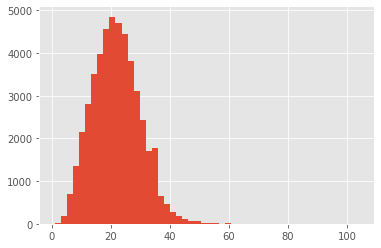

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()


In [ ]:
X = [[w[0]for w in s] for s in sentences]
y = [[w[1] for w in s] for s in sentences]

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)
batch_size = 32
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]


In [ ]:
train_data_X = [" ".join(z) for z in X_tr]
train_data_y = [" ".join(z) for z in y_tr]
test_data_X = [" ".join(z) for z in X_te]
test_data_y = [" ".join(z) for z in y_te]
valid_data_X = [" ".join(z) for z in X_val]
valid_data_y = [" ".join(z) for z in y_val]

In [ ]:
train_data_X = pd.DataFrame(train_data_X)
train_data_y = pd.DataFrame(train_data_y)
train_data = pd.concat([train_data_X,train_data_y],axis =1)
train_data.columns = ["sentence","tags"]

In [ ]:
test_data_X = pd.DataFrame(test_data_X)
test_data_y = pd.DataFrame(test_data_y)
test_data = pd.concat([test_data_X,test_data_y],axis =1)
test_data.columns = ["sentence","tags"]

In [ ]:
valid_data_X = pd.DataFrame(valid_data_X)
valid_data_y = pd.DataFrame(valid_data_y)
valid_data = pd.concat([valid_data_X,valid_data_y],axis =1)
valid_data.columns = ["sentence","tags"]

In [ ]:
train_data.to_csv("train_data.csv",index=None)
test_data.to_csv("test_data.csv",index=None)
valid_data.to_csv("valid_data.csv",index=None)

# **Step 3: Load Training Data, Testing Data and Validation Data**


In [ ]:
def load_dataset(drive_path, dataset):
  loaded_dataset = pd.read_csv(drive_path + dataset)     # Read CSV file
  print("="*40, "\n", loaded_dataset)                    # Print the dataset that we load in previous step
  return dataset

# **Step 4: Understand and Pre-process Training Data, Testing Data and Validation Data**


### **Step 4.1: Tokenize Text**

In [ ]:
def data_tokenization(s):
  return s.split()

### **Step 4.2: Build Training Data, Testing Data and Validation Data Objects**

In [ ]:
def data_objects(drive_path):
  # Declared a Field object
  # Field : A class that stores information about the way of preprocessing
  TEXT  = Field(sequential= True, tokenize = data_tokenization, lower = True, batch_first = False, fix_length=40,pad_token='<pad>')
  LABEL  = Field(tokenize = data_tokenization, batch_first = False,fix_length=40,pad_token='O')
  #LABEL = data.LabelField(dtype = torch.long)
  # TabularDataset : Defines a dataset of columns. Create a TabularDataset given a path, file format,
  # and Field list
  training_data, validation_data, testing_data = TabularDataset.splits(path = drive_path,
                                                            train       = 'train_data.csv',
                                                            validation  = 'valid_data.csv',
                                                            test        = 'test_data.csv',
                                                            format      = 'csv',
                                                            fields      = [('sentence', TEXT),('tags', LABEL)],
                                                            skip_header = True)


  return training_data, validation_data, testing_data, LABEL, TEXT

### **Step 4.3: Load Pre-Trained Word Embedding Vectors**

In [ ]:
def load_word_embedding_vectors(drive_path):
  # Load word embedding vectors from memory
  # I have downloaded the Glove word embedding vectors 100d from internet and saved in my drive
  # To use that, I simply give the path of that file and read file in my program using vocab.Vectors function
  vectors = vocab.Vectors('glove.6B.100d.txt', drive_path)
  return vectors

### **Step 4.4: Build Vocabulary**

In [ ]:
def build_vocabulary(training_data, validation_data , testing_data, vectors, LABEL, TEXT):
  # Note: Best practice when working with real world dataset build vocabulary only on Training Data
  TEXT.build_vocab(training_data, validation_data , testing_data, vectors=vectors, unk_init=torch.Tensor.normal_)   # Build vocabulary from input text
  LABEL.build_vocab(training_data, validation_data , testing_data)                   # Build vocabulary from output / labels (Encode all labels)

  print("\n=========================================")
  print("Output/Label word to index dictionary: ", LABEL.vocab.stoi)
  print("\n=========================================")
  print("Input Text word to index dictionary:\n ", TEXT.vocab.stoi,"\n")

  word_embeddings = TEXT.vocab.vectors   # Load vectors
  vocabulary_size = len(TEXT.vocab)      # Size of vocabulary
  return word_embeddings, vocabulary_size

# **Step 5: Represent Training Data, Testing Data and Validation Data in Machine Understandable Format**

In [ ]:
def data_iterators(training_data, validation_data, testing_data):
  # Iterators handle numericalizing, batching, packaging. Basically, it does all the heavy lifting necessary
  # to pass the data to a neural network
  # BucketIterator : Defines an iterator that batches examples of similar lengths together to minimizes the amount of padding needed
  # By using "splits" it applies processing steps on all datasets equally

  training_iterator, validation_iterator, testing_iterator = data.BucketIterator.splits((training_data, validation_data, testing_data), batch_size=32, sort_key=lambda x: len(x.sentence), repeat=False, shuffle=False)

  return training_iterator, validation_iterator, testing_iterator

In [ ]:
print("+============================Data Preparation============================+\n\n")

print("---Step 2: Load Training Data, Testing Data and Validation Data---")
print("\nTraining data")
original_training_data = load_dataset(drive_path,'train_data.csv')
print("\nValidation data")
original_training_data = load_dataset(drive_path,'valid_data.csv')
print("\nTesting data")
original_training_data = load_dataset(drive_path,'test_data.csv')


print("\n---Step 3: Understand and Pre-process Training Data, Testing Data and Validation Data---")
print("\n---Step 4: Represent Training Data, Testing Data and Validation Data in Machine Understandable Format---")
preprocessed_training_data, preprocessed_validation_data, preprocessed_testing_data, LABEL, TEXT = data_objects(drive_path)
# Load word embedding vectors from memory
vectors = load_word_embedding_vectors(drive_path)
# Build vocabulary
word_embeddings, vocabulary_size = build_vocabulary(preprocessed_training_data, preprocessed_validation_data, preprocessed_testing_data, vectors, LABEL, TEXT)
# Create iterator objects
training_iterator, validation_iterator, testing_iterator = data_iterators(preprocessed_training_data, preprocessed_validation_data, preprocessed_testing_data)

# **Step 6: Execute the Training Phase**

### **Step 6.1:Model Architecture**

In [ ]:

'''
    /*----------------------------- MODEL_ARCHITECTURE -------------
    | Class     : BLSTM()
    | Purpose   : To build the architecture of model to be trained
    *---------------------------------------------------------
    | nn.Module : Base class for all neural network modules. Your models should also subclass this class.
    |
    | Arguments:
    |      output_dim    : 18 (Classes of tags --> 12). For output layer number of nodes in output layer will be same as
    |                      number of outputs required in your problem
    |	     hidden_dim    : Size of the hidden layer. Here size of hidden_state of the lstm
    | 		 input_dim     : Size of the vocabulary containing unique words. Total number of unique words in sample data
    |		   embedding_dim : Size of each embedding vector. Here embeddding dimension of GloVe word embedding
    |                      vectors is 100 so embedding_dim = 100
    |		   weights       : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table
    *------------------------------------------------------------------------------------
    | Function  : forward()
    | Purpose   : This function will automatically start foward propogation when model object is called
    | Arguments :
    |     text  : Input text of shape = (num_sequences, batch_size)
	  | Return:
	  |     hidden_state : Final model state learned from input text
    ------------------------------------------------------------------------------
'''

class BLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, word_embeddings, n_layers, n_directions):

        super().__init__()

        self.n_layers     = n_layers
        self.n_directions = n_directions
        self.hidden_dim   = hidden_dim
        self.embedding_layer = nn.Embedding(input_dim, embedding_dim)          # Embedding layer shape
        # Assign pre-trained weights and update the weights during backpropagation
        self.embedding_layer.weight = nn.Parameter(word_embeddings, requires_grad = True)
        self.blstm_layer       = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = True, dropout = 0.2) # We can implement multiple layers of lstm simply by changing num_layers value
        self.linear_layer      = nn.Linear(hidden_dim * 2, output_dim)               # Shape of linear layer

    def forward(self, text):

        batch_size = text.shape[1]
        h_0, c_0 = self.init_hidden(batch_size)   # Initialize first hidden state to all zeros

        # Here we will map all the indexes present in the input sequence to the corresponding
		    # word vector using our trained word_embedddings.
	      # embedded input of shape = (num_sequences, batch_size, embedding_dimension)
        embedded_vectors = self.embedding_layer(text)

        output_state, (hidden_state, cell_state) = self.blstm_layer(embedded_vectors, (h_0, c_0))  # Apply blstm layer and start learning sequence of words

        hidden_state = self.linear_layer(output_state)      # Apply the linear layer on hidden_state / context vector
        return hidden_state
    def init_hidden(self,batch_size):
        h_0 = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_dim)
        return h_0, c_0

### **Step 6.2: Hyperparameters Settings**

In [ ]:
'''
/*---------------- INITIALIZE_PARAMETERS ------------------
'''

input_dimension      = len(TEXT.vocab)
embedding_dimension  = 100
hidden_dimension     = 512
output_dimension     = len(LABEL.vocab)
number_of_layers     = 2
number_of_directions = 2
number_of_epochs     = 2

### **Step 6.3: Create Model Object**

In [ ]:
model = BLSTM(input_dimension, embedding_dimension, hidden_dimension, output_dimension, word_embeddings, number_of_layers, number_of_directions)
print("\nModel Architecture\n==================\n")
model


Model Architecture



BLSTM(
  (embedding_layer): Embedding(31813, 100)
  (blstm_layer): LSTM(100, 512, num_layers=2, dropout=0.2, bidirectional=True)
  (linear_layer): Linear(in_features=1024, out_features=18, bias=True)
)

### **Step 6.4: Initialize Optimizer and Loss Function**

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)   # Initialize the optimizer
criterion = nn.CrossEntropyLoss()                     # Intialize loss function (also deals with Softmax)

### **Step 6.5: Evaluation Measure**

In [ ]:
def calculate_accuracy(prediction, label):

    rounded_preds = (torch.softmax(prediction,dim=1)).argmax(1)                    # Round predictions to the closest integer
    accuracy = accuracy_score(label, rounded_preds)

    return accuracy

In [ ]:
def calculate_f1(prediction, label):

    rounded_preds = (torch.softmax(prediction,dim=1)).argmax(1)                    # Round predictions to the closest integer
    f1 = f1_score(label, rounded_preds, average='weighted')


    return f1

### **Step 6.6: Calculate Epoch Elapsed Time**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time                   # Time elapsed by one epoch
    elapsed_mins = int(elapsed_time / 60)                  # Convert time in minutes
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60)) # Convert time in seconds
    return elapsed_mins, elapsed_secs, elapsed_time

### **Step 6.7: Train Model**

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss      = 0                                                 # Initialize epoch loss to 0
    epoch_accuracy  = 0                                                 # Initialize epoch accuracy to 0

    model.train()                                                       # Start model training mode

    for batch in iterator:

        optimizer.zero_grad()                                           # Clear all optimized gradients
        text = batch.sentence
        predictions = model(text)                # Make model predictions on training data

        output_dim = predictions.shape[-1]
        predictions = predictions.view(-1, output_dim)

        trg = batch.tags.view(-1)

        loss     = criterion(predictions, trg)                 # Calculate loss for each batch in epoch

        accuracy = calculate_accuracy(predictions, trg)        # Calculate accuracy for each batch in epoch

        loss.backward()                                                  # Start backward propogation
        optimizer.step()                                                 # Optimization of parameters

        epoch_loss      += loss.item()                                   # Add loss for all batches in one epoch
        epoch_accuracy  += accuracy.item()                               # Add accuracy for all batches in one epoch

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)    # Average loss and accuracy for one epoch and return

### **Step 6.8: Save Model**

In [ ]:
def save_model(drive_path):
  torch.save(model.state_dict(), drive_path + 'best-lstm-model.pt')


### **6.9 Evaluate Model**


*   **Function to be used in Validation and Test Phase**


In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss     = 0      # Initialize epoch loss to 0
    epoch_accuracy = 0      # Initialize epoch accuracy to 0
    epoch_f1 = 0
    model.eval()            # Start model evaluation mode

    with torch.no_grad():

        for batch in iterator:


            text = batch.sentence
            predictions = model(text)                # Make model predictions on data
            #loss = criterion(predictions, batch.tags)               # Calculate loss for each batch in epoch

            output_dim = predictions.shape[-1]
            predictions = predictions.view(-1, output_dim)

            trg = batch.tags.view(-1)

            loss     = criterion(predictions, trg)                 # Calculate loss for each batch in epoch

            accuracy = calculate_accuracy(predictions, trg)  # Calculate accuracy for each batch in epoch

            epoch_loss += loss.item()                                 # Add loss for all batches, in one epoch
            epoch_accuracy += accuracy.item()                         # Add accuracy for all batches in one epoch

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)  # Average loss and accuracy for one epoch and return


# **Step 7: Execute the Validation Phase**

In [ ]:
def validation(model, validation_iterator, criterion):
      best_validation_loss = float('inf')                                                        # Declare best validation loss variable
      validation_loss, validation_accuracy = evaluate(model, validation_iterator, criterion)     # Start model validation phase

      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        save_model(drive_path)                                   # Save model on epoch where the validation loss is lowest
      return validation_loss, validation_accuracy

# **Main Function**

In [ ]:
print("\n+=====================Execute the Training and Validation Phase=====================+\n\n")
# Step 5: Execute the Training Phase
t = 0
print("Model training....")
for epoch in range(number_of_epochs):

    start_time = time.time()                                    # Start time when one epoch will start executing

    training_loss, training_accuracy     = train(model, training_iterator, optimizer, criterion)   # Start model training

    # Step 7: Execute the Validation Phase
    validation_loss, validation_accuracy = validation(model, validation_iterator, criterion)

    end_time = time.time()                                       # End time when one epoch will end executing
    epoch_mins, epoch_secs, elapsed_time = epoch_time(start_time, end_time)    # Calculate time consumed by one epoch (in minutes and seconds)
    t+=elapsed_time
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTraining Loss: {training_loss:.3f}   | Training Accuracy: {training_accuracy*100:.2f}%')
    print(f'\tValidation Loss: {validation_loss:.3f} |  Validation Accuracy: {validation_accuracy*100:.2f}%')
model_elapsed_mins = int(t / 60)                  # Convert time in minutes
model_elapsed_secs = int(t - (model_elapsed_mins * 60)) # Convert time in seconds
print("\n+==========================Model Run-Time===========================+\n")
print(f'\t\t\tModel Run-Time: {model_elapsed_mins}m {model_elapsed_secs}s')




+=====================Execute the Training and Validation Phase=====================+


Model training....
Epoch: 01 | Epoch Time: 71m 36s
	Training Loss: 0.147   | Training Accuracy: 96.17%
	Validation Loss: 0.095 |  Validation Accuracy: 97.66%
Epoch: 02 | Epoch Time: 43m 38s
	Training Loss: 0.073   | Training Accuracy: 97.90%
	Validation Loss: 0.074 |  Validation Accuracy: 97.91%

+==========================Model Run-Time===========================+

			Model Run-Time: 115m 14s


# **Train Model on Training and Validation Data**

In [ ]:
tr_data, te_data = TabularDataset.splits(path = drive_path,
                                                            train       = 'train_valid_data.csv',
                                                            test       = 'test_data.csv',
                                                            format      = 'csv',
                                                            fields      = [('sentence', TEXT),('tags', LABEL)],
                                                            skip_header = True)

In [ ]:
tr_iterator, te_iterator = data.BucketIterator.splits((tr_data, te_data), batch_size=32, sort_key=lambda x: len(x.sentence), repeat=False, shuffle=False)

In [ ]:

print("\n+=====================Execute the Training Phase=====================+\n\n")
# Step 5: Execute the Training Phase
t = 0
model = BLSTM(input_dimension, embedding_dimension, hidden_dimension, output_dimension, word_embeddings, number_of_layers, number_of_directions)
model.load_state_dict(torch.load(drive_path + 'best-lstm-model.pt'))
print("Model training on complete data....")
for epoch in range(number_of_epochs):


    start_time = time.time()                                    # Start time when one epoch will start executing

    training_loss, training_accuracy     = train(model, training_iterator, optimizer, criterion)   # Start model training



    end_time = time.time()                                       # End time when one epoch will end executing
    epoch_mins, epoch_secs, elapsed_time = epoch_time(start_time, end_time)    # Calculate time consumed by one epoch (in minutes and seconds)
    t+=elapsed_time
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTraining Loss: {training_loss:.3f}   | Training Accuracy: {training_accuracy*100:.2f}%')
save_model(drive_path)
model_elapsed_mins = int(t / 60)                  # Convert time in minutes
model_elapsed_secs = int(t - (model_elapsed_mins * 60)) # Convert time in seconds
print("\n+==========================Model Run-Time===========================+\n")
print(f'\t\t\tModel Run-Time: {model_elapsed_mins}m {model_elapsed_secs}s')




+=====================Execute the Training Phase=====================+


Model training on complete data....
Epoch: 01 | Epoch Time: 35m 37s
	Training Loss: 0.054   | Training Accuracy: 98.38%
Epoch: 02 | Epoch Time: 37m 1s
	Training Loss: 0.054   | Training Accuracy: 98.37%

+==========================Model Run-Time===========================+

			Model Run-Time: 72m 38s


# **Step 8: Execute the Testing Phase**

### **Step 8.2: Test Model**

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss     = 0      # Initialize epoch loss to 0
    epoch_accuracy = 0      # Initialize epoch accuracy to 0
    epoch_f1 = 0
    model.eval()            # Start model evaluation mode

    with torch.no_grad():

        for batch in iterator:


            text = batch.sentence
            predictions = model(text)                # Make model predictions on data
            #loss = criterion(predictions, batch.tags)               # Calculate loss for each batch in epoch

            output_dim = predictions.shape[-1]
            predictions = predictions.view(-1, output_dim)

            trg = batch.tags.view(-1)

            loss     = criterion(predictions, trg)                 # Calculate loss for each batch in epoch

            accuracy = calculate_accuracy(predictions, trg)  # Calculate accuracy for each batch in epoch
            f1_score = calculate_f1(predictions, trg)
            epoch_loss += loss.item()                                 # Add loss for all batches, in one epoch
            epoch_accuracy += accuracy.item()                         # Add accuracy for all batches in one epoch
            epoch_f1+=f1_score

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator), epoch_f1 / len(iterator)  # Average loss and accuracy for one epoch and return


In [ ]:
print("\n+=====================Execute the Testing Phase=====================+\n\n")
# Step 8: Execute the Testing Phase
model = BLSTM(input_dimension, embedding_dimension, hidden_dimension, output_dimension, word_embeddings, number_of_layers, number_of_directions)
model.load_state_dict(torch.load(drive_path + 'best-lstm-model.pt'))

testing_loss, testing_accuracy, testing_f1 = evaluate(model, testing_iterator, criterion)   # Start model testing
print(f'Testing Loss: {testing_loss:.3f} | Testing Accuracy: {testing_accuracy*100:.2f}% | Testing F1 Score: {testing_f1*100:.2f}%')




+=====================Execute the Testing Phase=====================+


Testing Loss: 0.076 | Testing Accuracy: 97.87% | Testing F1 Score: 97.79%


# **Predictions**

In [ ]:
model.eval()            # Start model evaluation mode
i = 0
with torch.no_grad():
  for batch in testing_iterator:
    if i == 2:
      break
    else:
      text = batch.sentence

      predictions = model(text)                # Make model predictions on data

      output_dim = predictions.shape[-1]
      predictions = predictions.view(-1, output_dim)

      trg = batch.tags.view(-1)
      i = 2
rounded_preds = (torch.softmax(predictions,dim=1)).argmax(1)

In [ ]:
predictions = [LABEL.vocab.itos[i] for i in rounded_preds]
labels = [LABEL.vocab.itos[i] for i in trg]
print("True LABEL:", labels[:100])
print("Prediction:", predictions[:100])